# Multi-Modal RAG Hands-On Theory Notebook

## What is RAG?

![RAG Image](../data/rag.png)

Retrieval-Augmented Generation (RAG) is an AI technique that combines information retrieval with text generation. Instead of relying solely on a pre-trained language model’s internal knowledge, RAG dynamically retrieves relevant documents from an external knowledge base before generating a response.

## Why Rag?

![Why RAG Image](../data/why_rag.png)

1. **Improved Accuracy:** RAG enhances the factual correctness of generated responses by retrieving up-to-date and domain-specific information, reducing the likelihood of hallucinations (fabricated information).

2. **Better Generalization:** Since RAG dynamically retrieves relevant documents, it performs well across various domains without requiring extensive fine-tuning, making it more adaptable to new topics.

3. **Reduced Model Size Requirements:** Instead of embedding all knowledge within a large model, RAG leverages external databases, allowing for smaller, more efficient models while maintaining high-quality responses.

4. **Enhanced Explainability:** By referencing retrieved documents, RAG provides verifiable sources for its answers, making it more transparent and easier to trust compared to purely generative models.

5. **And more...**

## What is Multi-modal RAG?

Multi-modal Retrieval-Augmented Generation (RAG) extends the standard RAG approach by incorporating **multiple types of data**—such as text, images, or even audio—**into the retrieval and generation process**. Instead of working with a single modality (like just text), multi-modal RAG systems can query and generate content based on various forms of input, allowing for richer and more diverse responses. 

For example, when dealing with a document that contains both images and text, a multi-modal RAG system can retrieve relevant images along with the associated text, enhancing the quality and relevance of the generated response.


### Text+Images RAG

Multi-modal RAG (Retrieval-Augmented Generation) systems differ in how they handle text and images, depending on whether both the database and the language model (LLM) work with text and images together or focus on one modality. There are a lot of different approaches to reach this goal.

![Multi-Modal RAG Image](../data/multi_modal_rag.jpg)

Another approach not shown above is to consider the file as a series of images:
- **File-as-Images** → **Image DB** → **Retrieve Images** → **Multi-modal LLM** → **Text answer and sources**  
- In this case, the document is converted into a series of images (e.g., scanned pages), stored in an image-specific database, and sent as images to a multi-modal LLM, which generates textual answers based on the content of the images. The DB used is usually specialized for this task.

# Hands-on Example

In this exercise, you will learn how to implement a **Multimodal Retrieval-Augmented Generation (RAG)** pipeline from scratch, without relying on tools like `langchain`.  While `langchain` is a powerful framework that simplifies the development of RAG pipelines, it can sometimes lack flexibility for custom implementations, as it abstracts many components.

Here, two different vector store are used to **store the images and text separately**.

The different components of the pipeline are:

- **Text and image extraction from PDFs** – Extract raw text and images from PDF files to make the content processable.  
- **Text and image chunking** – Break the extracted text and images into smaller, meaningful segments to improve retrieval efficiency.  
- **Embedding of the chunks (text and images)** – Convert text and image chunks into numerical representations (embeddings) using pre-trained models.  
- **Storage of the embeddings in a vector store** – Save both text and image embeddings in a specialized database (vector store) to enable fast similarity searches.  
- **Relevant chunks retrieval** – Query the vector store to find the most relevant text and image chunks based on user input.  
- **Setting and prompting of the LLM for a RAG** – Structure prompts and configure the language model to integrate retrieved text and image information into its responses.  
- **Additional tools for improved retrieval** – Use techniques like query expansion to reformulate user queries for better recall and reciprocal rank fusion to combine results from multiple retrieval methods.  
- **Final multimodal RAG pipeline implementation** – Integrate all components into a complete system that retrieves relevant information (both text and images) and generates enhanced responses using the language model.

**Note:** To complete this exercise, you need an OpenAI API key, the PDF files with images, and the necessary libraries installed (see `requirements.txt`).

The example is applied to `Explainable_machine_learning_prediction_of_edema_a.pdf`. Please, have a quick look at it before starting the exercise.

We will try to answer the following question:

In [1]:
test_question = "According to SHAP analysis, which factors were the most influential in predicting higher-grade edema (Grade 2+)?"

## Setup

In [2]:
!pip install -r requirements.txt

In [3]:
import io
import os
import getpass
import json
from tqdm import tqdm

import numpy as np

import base64
import matplotlib.pyplot as plt
from PIL import Image

from src.constants_and_data_classes import Chunk, DataType
from src.data_processing import PDFExtractor, SimpleChunker
from src.embedding import (
    OpenAITextEmbeddings,
    ImageEmbeddings,
    ImageEmbeddingsForText,
    compute_openai_large_embedding_cost,
)
from src.vectorstore import (
    ChromaDBVectorStore,
    VectorStoreRetriever,
)
from src.llm import OpenAILLM
from src.rag import Generator, DefaultRAG

In [4]:
data_folder = "../data"

example_pdf_file = "Explainable_machine_learning_prediction_of_edema_a.pdf"
example_pdf_path = os.path.join(data_folder, example_pdf_file)

text_vector_store_collection = "text_collection"
image_vector_store_collection = "image_collection"

text_vector_store_full_collection = "text_collection_full"
image_vector_store_full_collection = "image_collection_full"

In [5]:
os.environ["OPENAI_API_KEY"] = getpass.getpass()

## LLM  

The LLM is the core of the RAG system, responsible for generating responses based on the retrieved information. There are many options available on-premise or online, each with different performance, speed, specialized knowledge and cost trade-offs.

In this case a **multi-modal LLM is required**, we use `gpt-4o-mini`.  

This LLM expects input in the form of a list of messages, where each message includes the content and the role of the speaker (e.g., developer, user, assistant).  

Images can be provided to this LLM as `base64`, but only when the role is set to `user`.

Here is how messages are defined here:

```python
class Roles(str, Enum):
    DEVELOPER = "developer" # Previously, system
    USER = "user"
    ASSISTANT = "assistant"
    TOOL = "tool"

class LLMMessage(BaseModel):
    content: Optional[str] = None
    role: Optional[Roles] = None
```

In [6]:
llm = OpenAILLM(temperature=0.5)

OpenAI LLM loaded: gpt-4o-mini; temperature: 0.5; seed: 42


In [7]:
print(test_question)

According to SHAP analysis, which factors were the most influential in predicting higher-grade edema (Grade 2+)?


In [8]:
answer, price = llm.generate([{"role": "user", "content": test_question}], verbose=True)

Total input tokens: 30
Total output tokens: 356
Total tokens: 386
Estimated cost: $0.0002


In [9]:
print(answer.content)

SHAP (SHapley Additive exPlanations) analysis is a method used to interpret the output of machine learning models by assigning each feature an importance value for a particular prediction. While I don't have access to specific datasets or studies conducted after October 2023, I can provide general guidance on factors that are commonly influential in predicting higher-grade edema (Grade 2+) based on existing medical literature and common clinical practices.

Factors that may be influential in predicting higher-grade edema can include:

1. **Patient Demographics**: Age, sex, and ethnicity can play a role in edema development.
2. **Medical History**: Previous conditions such as heart disease, kidney disease, or liver dysfunction.
3. **Medications**: Certain medications, like corticosteroids or non-steroidal anti-inflammatory drugs (NSAIDs), can contribute to fluid retention.
4. **Body Mass Index (BMI)**: Higher BMI can be associated with increased risk of edema.
5. **Comorbidities**: Cond

## PDF Text and Images Extraction  

The first step in the pipeline is to extract text and images from the document.  

In this exercise, we use the `MinerU` library, which under the hood uses among others `doclayout_yolo` for segmentation. Note that this model is not commercially permissive.

The choice of extraction tool should be carefully considered. Depending on the document type and formatting, different methods may be required to preserve text integrity and leverage structural elements such as headings, tables, or metadata for better processing (`pdfplumber` (better for tables), `Tesseract OCR` (for scanned PDFs), ect.).

Extracting images can be challenging, as **irrelevant images** (such as logos) are often included, and some images may be **split into multiple images**. It may also be helpful to link the position of images to nearby text for more accurate retrieval. Specialized tools or methods might be required to efficiently handle images embedded in the document.

In [10]:
data_extractor = PDFExtractor()
_, text, images = data_extractor.extract_text_and_images(example_pdf_path)

API IS NOT REACHABLE!
Using fallback extractor instead: performances might be worse and notebook comments might not be matching the outputs!
HTTPSConnectionPool(host='vlm2vec-pdf-api.runai-innovation-clement.inference.compute.datascience.ch', port=443): Max retries exceeded with url: /v1/pdf_to_markdown (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:997)')))


In [11]:
print(text[:1000])

### Received: 30 April 2024  |  Revised: 5 July 2024  |  Accepted: 4 August 2024

[DOI: 10.1111/cts.70010](https://doi.org/10.1111/cts.70010)

**A R T I C L E**
# **Explainable machine learning prediction of edema adverse ** **events in patients treated with tepotinib**
## Federico Amato [1] |  Rainer Strotmann [2] |  Roberto Castello [1] |  Rolf Bruns [2] | Vishal Ghori [3] |  Andreas Johne [2] |  Karin Berghoff [2] |  Karthik Venkatakrishnan [4] |
### **Nadia Terranova [5]**


1 Swiss Data Science Center (EPFL and

ETH Zurich), Lausanne, Switzerland

2 The healthcare business of Merck

KGaA, Darmstadt, Germany

3 Ares Trading S.A., Eysins, Switzerland,

an affiliate of Merck KGaA, Darmstadt,

Germany

4 EMD Serono, Billerica, Massachusetts,

USA

5 Quantitative Pharmacology, Ares
Trading S.A., Lausanne, Switzerland,

an affiliate of Merck KGaA, Darmstadt,

Germany

**Correspondence**

Nadia Terranova, Quantitative

Pharmacology, Ares Trading S.A.,

Lausanne, Switzerland, an affiliate

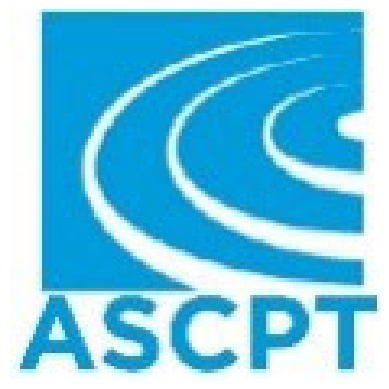

In [12]:
img_data = base64.b64decode(images[2]["image_base64"])
img = Image.open(io.BytesIO(img_data))

plt.imshow(img)
plt.axis("off")
plt.show()

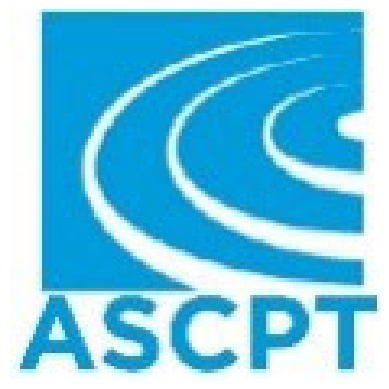

In [13]:
img_data = base64.b64decode(images[0]["image_base64"])
img = Image.open(io.BytesIO(img_data))

plt.imshow(img)
plt.axis("off")
plt.show()

## Chunking

The second step is to split the extracted text into smaller chunks, which will later be embedded and retrieved efficiently. 

In this exercise, we use a simple heuristic approach: the text is split iteratively—first by heading levels (`#`), then by line breaks (`\n`), and finally by sentence (`.`). Splitting only occurs if the resulting chunk exceeds a predefined length. However, more advanced techniques exist, such as **semantic chunking** (which splits based on meaning rather than syntax) or **agentic chunking** (which dynamically adapts chunk sizes based on context).

**Images are treated as separate chunks**, but with a different `DataType`. Additional relevant metadata can also be included, such as the image's position relative to the text or its caption, if available. They are stored in another list.

Each chunk is enriched with metadata, including:  
- **Source file** – The document from which the chunk originates.  
- **Chunk counter** – The position of the chunk within the file.  
- **Unique identifier (`chunk_id`)** – Ensures each chunk can be referenced independently.  
- **Data type** - The document type (image or text).

Additional metadata could be included to enable more refined filtering and retrieval strategies.  

```python
class DataType(str, Enum):
    TEXT = "text"
    IMAGE = "image"


class Chunk(BaseModel):
    chunk_id: int
    content: str
    metadata: dict = Field(default_factory=dict)
    data_type: Optional[DataType] = None
    score: Optional[float] = None
```


In [14]:
chunker = SimpleChunker()
text_chunks = chunker.chunk_text(text, {"source_text": example_pdf_file})
image_chunks = chunker.chunk_images(images, {"source_text": example_pdf_file})

In [15]:
print(len(text_chunks))
text_chunks[0]

56


Chunk(chunk_id=0, content='### Received: 30 April 2024  |  Revised: 5 July 2024  |  Accepted: 4 August 2024 [DOI: 10.1111/cts.70010](https://doi.org/10.1111/cts.70010) **A R T I C L E** # **Explainable machine learning prediction of edema adverse ** **events in patients treated with tepotinib** ## Federico Amato [1] |  Rainer Strotmann [2] |  Roberto Castello [1] |  Rolf Bruns [2] | Vishal Ghori [3] |  Andreas Johne [2] |  Karin Berghoff [2] |  Karthik Venkatakrishnan [4] | ### **Nadia Terranova [5]** 1 Swiss Data Science Center (EPFL and ETH Zurich), Lausanne, Switzerland 2 The healthcare business of Merck KGaA, Darmstadt, Germany 3 Ares Trading S.A., Eysins, Switzerland, an affiliate of Merck KGaA, Darmstadt, Germany 4 EMD Serono, Billerica, Massachusetts, USA 5 Quantitative Pharmacology, Ares Trading S.A., Lausanne, Switzerland, an affiliate of Merck KGaA, Darmstadt, Germany **Correspondence** Nadia Terranova, Quantitative Pharmacology, Ares Trading S.A., Lausanne, Switzerland, an a

18


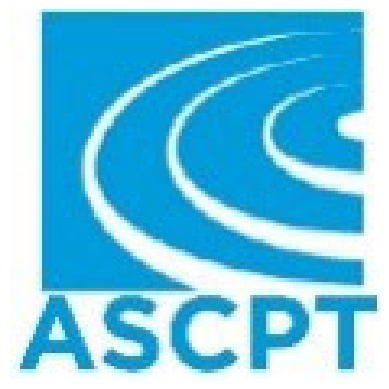

In [16]:
print(len(image_chunks))

img_data = base64.b64decode(image_chunks[2].content)
img = Image.open(io.BytesIO(img_data))

plt.imshow(img)
plt.axis("off")
plt.show()

## Embedding Models  

Once the text and images are divided into chunks, each chunk is converted into a numerical representation (embedding) that captures its meaning.  

For text, we use OpenAI’s `text-embedding-3-large`, but other options exist, each with different trade-offs in on-premise vs online, accuracy, speed, and cost. The choice of model depends on the specific needs of the retrieval task.

For images, we utilize `VLM2Vec`. Similar to text embeddings, various options exist for image embeddings, each with its own trade-offs. There will be one embedding model to convert images to vector representation, and another to convert the user query into the same representation.

In [17]:
_ = compute_openai_large_embedding_cost(text_chunks, verbose=True)

text_embedding_model = OpenAITextEmbeddings()
text_embeddings = text_embedding_model.get_embedding(
    [chunk.content for chunk in text_chunks]
)

print(text_embeddings.shape)
text_embeddings[0]

Total tokens: 12018
Estimated cost: $0.0016
(56, 3072)


array([-0.04075094,  0.01728425, -0.01052012, ...,  0.00718792,
        0.00769066, -0.00255109], shape=(3072,))

In [18]:
image_embeddings = []

image_embedding_model = ImageEmbeddings()
for chunk in tqdm(image_chunks):
    image_embeddings.append(image_embedding_model.get_embedding(chunk.content))


image_embeddings = np.array(image_embeddings)

  0%|          | 0/18 [00:00<?, ?it/s]

API IS NOT REACHABLE!
Using fallback image embedding instead, performances will be worse and notebook comments might not be matching the outputs!
HTTPSConnectionPool(host='vlm2vec-pdf-api.runai-innovation-clement.inference.compute.datascience.ch', port=443): Max retries exceeded with url: /v1/image_embeddings (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:997)')))


c:\Users\sieverin\Anaconda3\envs\advanced-llm-workshop\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
100%|██████████| 18/18 [00:07<00:00,  2.28it/s]


In [19]:
# Also define the text embedding for the image-text embedding model
image_text_embedding_model = ImageEmbeddingsForText()

## Vector Store and Retrieval  

After embedding the chunks, they need to be stored for efficient retrieval. The choice of vector store depends on factors like accuracy, speed, and filtering options. In this exercise, we use `ChromaDB`.  

The next step is retrieving the most relevant chunks based on a query. In this implementation, the retriever uses only embeddings (sparse search). However, in some cases, dense search methods like BM25 or hybrid approaches combining both sparse and dense search can be used for better accuracy when retrieving the text. Some retrieval strategies also use the metadata.

Text and image embeddings are stored separately here, thus their similarities cannot be directly compared. As a consequence, the retrieval strategy implemented here is to take the `top_k` for each datatype.


In [20]:
vector_store_text = ChromaDBVectorStore(text_vector_store_collection)
vector_store_text.insert_chunks(text_chunks, text_embeddings)

In [21]:
vector_store_image = ChromaDBVectorStore(image_vector_store_collection)
vector_store_image.insert_chunks(image_chunks, image_embeddings)

In [22]:
retriever = VectorStoreRetriever(
    text_embedding_model,
    vector_store_text,
    image_text_embedding_model,
    vector_store_image,
)

results = retriever.retrieve(test_question, top_k_text=5, top_k_image=1)

API IS NOT REACHABLE!
Using fallback text embedding for images embedding instead,performances will be worse and notebook comments might not be matching the outputs!
HTTPSConnectionPool(host='vlm2vec-pdf-api.runai-innovation-clement.inference.compute.datascience.ch', port=443): Max retries exceeded with url: /v1/text_embeddings (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:997)')))


{'chunk_id': '29', 'score': 0.5873426198959351, 'chunk': Chunk(chunk_id=29, content='Consistently with the above sensitivity analysis, past current edema grade was found to be the most influential input, particularly if a same grade persisted to the following safety visit. The exposure- \xadderived features were also informative for the model probability predictions. Albumin was found as the most informative time- \xadvarying covariate, especially for predicting edemas of grades 2+. Figure 3 illustrates the contribution of the input variables toward the predicted probability of edemas of grades 2+. The analysis reveals that the current edema grade is the most informative input, as patients with a history of edemas of grades 2+ are considered highly likely to experience the same grade in the future. Interestingly, albumin once again emerges as the most informative among the longitudinal covariates, with lower levels associated', metadata={'source_text': 'Explainable_machine_learning_pre

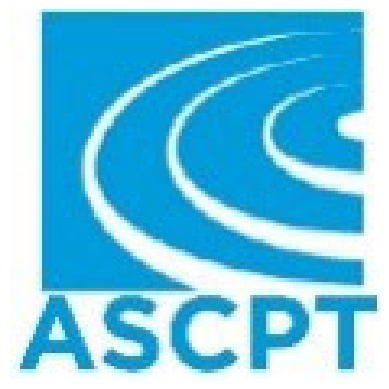

In [23]:
for result_l in results:
    for result in result_l:
        if result["chunk"].data_type == DataType.TEXT:
            print(result)
        elif result["chunk"].data_type == DataType.IMAGE:
            print(f"Chunk ID: {result['chunk_id']} | Score: {result['score']}")
            img_data = base64.b64decode(result["chunk"].content)
            img = Image.open(io.BytesIO(img_data))
            plt.imshow(img)
            plt.axis("off")
            plt.show()

## Generator  

Once the LLM is set up, a specific prompt needs to be defined for the RAG system. This prompt must include the retrieved chunks as context. The prompt has to be adapted to each specific project.

In addition to the basic prompt, we incorporate **prompt engineering** by asking the LLM to justify its answer. The model is also instructed to indicate which chunks were most relevant in forming its response, improving **interpretability**, and to provide the answer in **JSON format** for easier data management.

In [24]:
default_developer_prompt = """You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer."""
print(default_developer_prompt)

You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.


In [25]:
default_rag_template = """
Here are the relevant CHUNKS:
{context}

--------------------------------------------

Here is the USER QUESTION:
{query}

--------------------------------------------

Please think step-by-step and generate your output in json:
"""
print(default_rag_template)


Here are the relevant CHUNKS:
{context}

--------------------------------------------

Here is the USER QUESTION:
{query}

--------------------------------------------

Please think step-by-step and generate your output in json:



In [26]:
generator = Generator(llm, default_developer_prompt, default_rag_template)

You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.

Here are the relevant CHUNKS:


Chunk 1: 
Image from chunk 1 attached in next messages.

Chunk 2: 
### Received: 30 April 2024  |  Revised: 5 July 2024  |  Accepted: 4 August 2024 [DOI: 10.1111/cts.70010](https://doi.org/10.1111/cts.70010) **A R T I C L E** # **Explainable machine learning prediction of edema adverse ** **events in patients treated with tepotinib** ## Federico Amato [1] |  Rainer Strotmann [2] |  Roberto Castello [1] |  Rolf Bruns [2] | Vishal Ghori [3] |  Andreas Johne [2] |  Karin Berghoff [2] |  Karthik Venkatakri

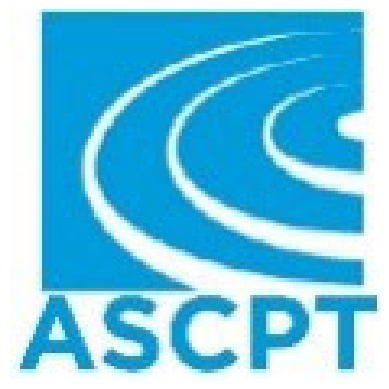

Total input tokens: 8999
Total output tokens: 105
Total tokens: 9104
Estimated cost: $0.0014


In [27]:
answer, cost = generator.generate(
    history=[],
    query=test_question,
    chunks=[
        Chunk(
            chunk_id=0,
            data_type=DataType.IMAGE,
            content=image_chunks[2].content,
            metadata={},
        ),
        Chunk(
            chunk_id=1,
            data_type=DataType.TEXT,
            content=text_chunks[0].content,
            metadata={},
        ),
    ],
    verbose=True,
)

In [28]:
print(answer.content)

{
  "step_by_step_thinking": "The user is asking about the SHAP analysis related to predicting higher-grade edema (Grade 2+). However, the provided chunks do not contain specific details about the factors identified by SHAP analysis. Therefore, I cannot provide a direct answer to the user's question based on the available information.",
  "chunk_used": [],
  "answer": "The chunks do not provide information on the factors influencing higher-grade edema (Grade 2+) according to SHAP analysis."
}


In [29]:
print(cost)

0.0014128499999999998


## RAG "Tricks"  

There are several methods to improve the efficiency of a RAG pipeline, such as query contextualization, query reformulation, re-ranking, query expansion, etc. For the sake of time, none of those has been implemented here.

## RAG  

Finally, the RAG pipeline is defined by integrating all the previously discussed components into a unified process.

## Only with text

In [30]:
rag_without_images = DefaultRAG(
    llm=llm,
    text_embedding_model=text_embedding_model,
    text_vector_store=vector_store_text,
    generator=generator,
    params={"top_k_text": 5},
)

In [31]:
print(test_question)

According to SHAP analysis, which factors were the most influential in predicting higher-grade edema (Grade 2+)?


In [32]:
answer, sources, cost = rag_without_images.execute(test_question, {}, verbose=True)

You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.

Here are the relevant CHUNKS:


Chunk 1: 
Consistently with the above sensitivity analysis, past current edema grade was found to be the most influential input, particularly if a same grade persisted to the following safety visit. The exposure- ­derived features were also informative for the model probability predictions. Albumin was found as the most informative time- ­varying covariate, especially for predicting edemas of grades 2+. Figure 3 illustrates the contribution of the input variables toward the predicted probability of ede

In [33]:
print(json.dumps(answer, indent=3))

{
   "step_by_step_thinking": "To answer the question, I analyzed the provided chunks for information related to SHAP analysis and its findings on factors influencing higher-grade edema (Grade 2+). From Chunk 1, it is clear that the current edema grade and albumin levels are highlighted as significant predictors. Chunk 2 confirms that higher albumin levels are associated with a reduced risk of Grade 2+ edema, while lower albumin levels correlate with an increased risk. Additionally, age over 70 years is mentioned as a factor associated with a greater likelihood of Grade 2+ edema in Chunk 2. Finally, Chunk 5 reiterates the impact of albumin and age on predicting the likelihood of higher-grade edema. Therefore, the most influential factors according to the SHAP analysis are the current edema grade, albumin levels, and age.",
   "chunk_used": [
      1,
      2,
      5
   ],
   "answer": "The most influential factors in predicting higher-grade edema (Grade 2+) according to SHAP analysis 

In [34]:
# The chunks retrieved by the retriever:
print(len(sources))
print(sources[0])

5
{'chunk_id': '29', 'chunk': Chunk(chunk_id=29, content='Consistently with the above sensitivity analysis, past current edema grade was found to be the most influential input, particularly if a same grade persisted to the following safety visit. The exposure- \xadderived features were also informative for the model probability predictions. Albumin was found as the most informative time- \xadvarying covariate, especially for predicting edemas of grades 2+. Figure 3 illustrates the contribution of the input variables toward the predicted probability of edemas of grades 2+. The analysis reveals that the current edema grade is the most informative input, as patients with a history of edemas of grades 2+ are considered highly likely to experience the same grade in the future. Interestingly, albumin once again emerges as the most informative among the longitudinal covariates, with lower levels associated', metadata={'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'd

In [35]:
print(cost)

0.00032189999999999996


## With text and images

In [36]:
rag = DefaultRAG(
    llm=llm,
    text_embedding_model=text_embedding_model,
    text_vector_store=vector_store_text,
    image_text_embedding_model=image_text_embedding_model,
    image_vector_store=vector_store_image,
    generator=generator,
    params={"top_k_text": 5, "top_k_image": 1},
)

In [37]:
print(test_question)

According to SHAP analysis, which factors were the most influential in predicting higher-grade edema (Grade 2+)?


You are a helpful assistant, and your task is to answer questions using relevant chunks and images. Please first think step-by-step by mentioning which chunks you used and then answer the question. Organize your output in a json formatted as dict{"step_by_step_thinking": Str(explanation), "chunk_used": List(integers), "answer": Str{answer}}. Your responses will be read by someone without specialized knowledge, so please have a definite and concise answer.

Here are the relevant CHUNKS:


Chunk 1: 
Consistently with the above sensitivity analysis, past current edema grade was found to be the most influential input, particularly if a same grade persisted to the following safety visit. The exposure- ­derived features were also informative for the model probability predictions. Albumin was found as the most informative time- ­varying covariate, especially for predicting edemas of grades 2+. Figure 3 illustrates the contribution of the input variables toward the predicted probability of ede

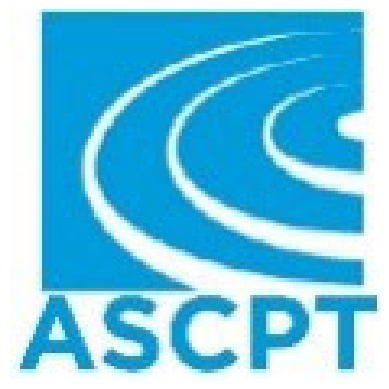

Total input tokens: 9745
Total output tokens: 213
Total tokens: 9958
Estimated cost: $0.0016


In [38]:
answer, sources, cost = rag.execute(test_question, {}, verbose=True)

In [39]:
print(json.dumps(answer, indent=3))

{
   "step_by_step_thinking": "To answer the question, I analyzed the provided chunks to identify the factors that are most influential in predicting higher-grade edema (Grade 2+). From Chunk 1, it is noted that the current edema grade is the most informative input, particularly if a same grade persisted to the following safety visit. Chunk 2 highlights that lower albumin levels are associated with a higher risk of edema of grade 2+, and that age greater than 70 years also increases the likelihood of higher-grade edemas. Chunk 5 confirms that older subjects are associated with an increased probability of edemas of grade 2+. Therefore, the most influential factors identified are current edema grade, albumin levels, and age.",
   "chunk_used": [
      1,
      2,
      5
   ],
   "answer": "The most influential factors in predicting higher-grade edema (Grade 2+) according to SHAP analysis are the current edema grade, lower albumin levels, and age greater than 70 years."
}


In [40]:
# The chunks retrieved by the retriever:
print(len(sources))
print(sources[0])

6
{'chunk_id': '29', 'chunk': Chunk(chunk_id=29, content='Consistently with the above sensitivity analysis, past current edema grade was found to be the most influential input, particularly if a same grade persisted to the following safety visit. The exposure- \xadderived features were also informative for the model probability predictions. Albumin was found as the most informative time- \xadvarying covariate, especially for predicting edemas of grades 2+. Figure 3 illustrates the contribution of the input variables toward the predicted probability of edemas of grades 2+. The analysis reveals that the current edema grade is the most informative input, as patients with a history of edemas of grades 2+ are considered highly likely to experience the same grade in the future. Interestingly, albumin once again emerges as the most informative among the longitudinal covariates, with lower levels associated', metadata={'source_text': 'Explainable_machine_learning_prediction_of_edema_a.pdf', 'd

In [41]:
print(cost)

0.00158955


----------------